In [1]:
# import the libraries need to be used
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
%matplotlib inline

In [4]:
# import the data processed and used by last article
data = pd.read_csv("HK/top3.csv").drop('Unnamed: 0', axis = 1)
geo_data  = gpd.read_file("HK/Hong_Kong_18_Districts/Hong_Kong_18_Districts.shp").drop('TCNAME', axis = 1)

In [5]:
# Filter out extremely high price and drop some useless columns
data = data[data.price <= 	     6000].drop(['host_id','minimum_nights','number_of_reviews'                ,'calculated_host_listings_count','availability_365'], axis = 1)
geo_data = geo_data.drop(['OBJECTID','Shape__Are','Shape__Len'], axis = 1)

In [6]:
geo_data.loc[geo_data.ENAME == 'YAU TSIM MONG',"geometry_lat"] = 22.295062
geo_data.loc[geo_data.ENAME == 'YAU TSIM MONG',"geometry_lon"] = 114.171865
geo_data.loc[geo_data.ENAME == 'WAN CHAI',"geometry_lat"] = 22.280025 
geo_data.loc[geo_data.ENAME == 'WAN CHAI',"geometry_lon"] = 114.173477
geo_data.loc[geo_data.ENAME == 'CENTRAL & WESTERN',"geometry_lat"] = 22.280641
geo_data.loc[geo_data.ENAME == 'CENTRAL & WESTERN',"geometry_lon"] = 114.159040

In [7]:
# Merge two data frames into one data frame
top_3 = pd.merge(data, geo_data, how='inner', left_on='neighbourhood', right_on='ENAME').drop(['ENAME',], axis = 1).drop(['geometry'], axis=1)
top_3.head()

,id,neighbourhood,latitude,longitude,room_type,price,geometry_lat,geometry_lon
0,69074,CENTRAL & WESTERN,22.28352,114.15018,Entire home/apt,1408,22.280641,114.15904
1,103760,CENTRAL & WESTERN,22.28407,114.15570,Entire home/apt,853,22.280641,114.15904
2,132773,CENTRAL & WESTERN,22.28868,114.14494,Entire home/apt,1056,22.280641,114.15904
3,133390,CENTRAL & WESTERN,22.28343,114.15539,Entire home/apt,939,22.280641,114.15904
4,163214,CENTRAL & WESTERN,22.28494,114.15251,Entire home/apt,1048,22.280641,114.15904


In [8]:
import geopy.distance

In [9]:
# Using two different algorithm to calculate distance
top_3['distance_geodesic'] = top_3.apply(
    (lambda row: geopy.distance.geodesic(
        (row['latitude'], row['longitude']),
        (row['geometry_lat'], row['geometry_lon'])
    ).m),
    axis=1
)
top_3['distance_great_circle'] = top_3.apply(
    (lambda row: geopy.distance.great_circle(
        (row['latitude'], row['longitude']),
        (row['geometry_lat'], row['geometry_lon'])
    ).m),
    axis=1
)

# Linear Model

In [10]:
# Import the libraries of linear regression
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [11]:
# Find out all unique values of room_type
set(top_3.room_type)

{'Entire home/apt', 'Private room', 'Shared room'}

In [12]:
# Extract the data of YAU TSIM MONG
yau = top_3[top_3.neighbourhood == 'YAU TSIM MONG']
# Divide the data by their room types
yau_en = yau[yau.room_type == 'Entire home/apt']
yau_pr = yau[yau.room_type == 'Private room']
yau_sh = yau[yau.room_type == 'Shared room']

In [13]:
# Define the X and Y, and then fit them into linear model
x1 = yau_en[['distance_geodesic']]
y1 = yau_en[['price']]
model = LinearRegression()
model.fit(x1,y1)
# Get the predicted y from trained model
yau_en_pred = model.predict(x1)

In [14]:
x2 = yau_pr[['distance_geodesic']]
y2 = yau_pr[['price']]
model = LinearRegression()
model.fit(x2,y2)
yau_pr_pred = model.predict(x2)

In [15]:
x3 = yau_sh[['distance_geodesic']]
y3 = yau_sh[['price']]
model = LinearRegression()
model.fit(x3,y3)
yau_sh_pred = model.predict(x3)

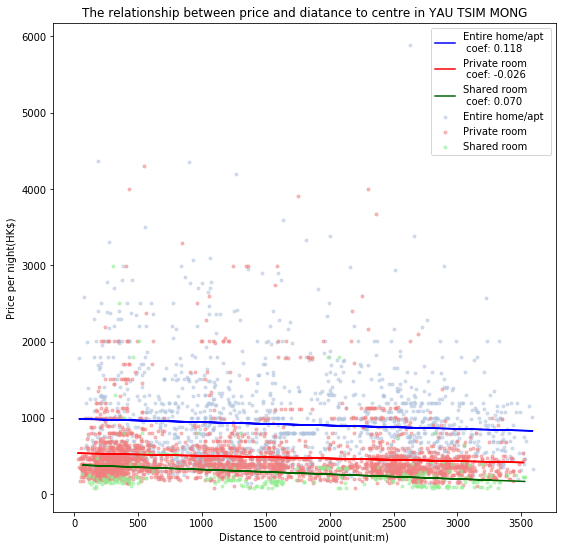

In [16]:
# Plot outputs
plt.figure(figsize=(9,9))
plt.scatter(yau_en.distance_geodesic, yau_en.price, marker = '.', color = 'lightsteelblue', alpha = 0.5 ,label = 'Entire home/apt')
plt.scatter(yau_pr.distance_geodesic, yau_pr.price, marker = '.', color = 'lightcoral', alpha = 0.5, label ='Private room')
plt.scatter(yau_sh.distance_geodesic, yau_sh.price, marker = '.', color = 'lightgreen', alpha = 0.5, label ='Shared room')
plt.plot(x1, yau_en_pred, color = 'blue', label ='Entire home/apt \n coef: 0.118')
plt.plot(x2, yau_pr_pred, color = 'red', label ='Private room \n coef: -0.026')
plt.plot(x3, yau_sh_pred, color = 'darkgreen', label ='Shared room \n coef: 0.070')
plt.gca().set_xlabel('Distance to centroid point(unit:m)')
plt.gca().set_ylabel('Price per night(HK$)')
plt.legend()
plt.title('The relationship between price and diatance to centre in YAU TSIM MONG')
plt.show()